# Использование библиотек NumPy, SciPy
*Выполнения заданий представлены Кузиной Екатериной*

In [44]:
import sympy as sp
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import rayleigh
from scipy.stats import linregress

In [2]:
from tqdm import tqdm

## 1. Построение распределений
Сгенерировать выборку с [распределением Рэлэя](https://ru.wikipedia.org/wiki/Распределение_Рэлея) используя numpy и scipy и построить на основе ее кривую плотности распределения на основе гистограммы из Matplotlib.

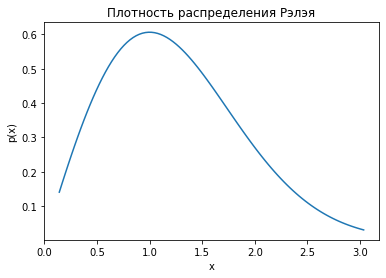

In [101]:
x = np.linspace(rayleigh.ppf(0.01), rayleigh.ppf(0.99), 100)
y = rayleigh.pdf(x)
plt.plot(x,y)
plt.xlabel('x')
plt.ylabel('p(x)')
plt.title('Плотность распределения Рэлэя')
None

## 2. Построение графика на по функции
Сгенерировать массивы по функции $(x^2 + y^2 - 1)^3 - x^2 y^3 = 0$ и построить на основе них график.

In [4]:
x_sqr= sp.Symbol('x_sqr', positive=True, real=True)
y= sp.Symbol('y', real=True)
eq = (x_sqr+y**2-1)**3-x_sqr*y**3

In [5]:
x_arr = np.linspace(0,1.4,50)

In [ ]:
y_vals = []
x_vals = []
for value in tqdm(x_arr):
  vals = sp.solve(eq.subs(x_sqr,value),y)
  if vals: 
    x_vals.append(value)
    y_vals.append(vals)

In [ ]:
fig = plt.figure(figsize=(6, 6), dpi=80)

plt.plot(x_vals, np.array(y_vals)[:,0])
plt.plot(x_vals, np.array(y_vals)[:,1])
plt.plot(np.array(x_vals)*-1, np.array(y_vals)[:,0])
plt.plot(np.array(x_vals)*-1, np.array(y_vals)[:,1])

plt.grid()
plt.xlabel('x')
plt.ylabel('y')
None

## 3. Анализ зависимостей

Найти зависимости представленные в датасете приложенном к заданию.
Виды зависимостей:  
 - корреляция
 - зависимость
 - независимость
 - типичные значения
 - выбросы
 - кластеры

In [2]:
import requests as req

In [3]:
data = req.get('https://lhd8ts4trw.a.trbcdn.net/cdn/yusuciqe45/00_data_engineer/dataset_home.txt')

In [4]:
values = []
rows = data.text.split('\n')
for row in rows:
  row = row.split(',')
  values.append(row)

In [5]:
values[:3]

[['20', 'female', '28.975', '0', 'no', 'northwest', '2257.47525'],
 ['44', 'male', '31.35', '1', 'yes', 'northeast', '39556.4945'],
 ['47', 'female', '33.915', '3', 'no', 'northwest', '10115.00885']]

In [6]:
header = ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

In [7]:
data = np.array(values).T

data.shape

(7, 670)

In [8]:
for ind in [1,4,5]:
  print(header[ind], np.unique(data[ind]), sep='\t')

sex	['female' 'male']
smoker	['no' 'yes']
region	['northeast' 'northwest' 'southeast' 'southwest']


In [9]:
def encoding(data):
  unique_values = np.unique(data)

  if len(unique_values) == 2:
    replaced_data = np.where(data == unique_values[0], 0, 1)
  else:
    replaced_data = data  
    for val in enumerate(unique_values):
      replaced_data = np.where(replaced_data == val[1], val[0], replaced_data)
  
  return replaced_data

In [10]:
data[1] = encoding(data[1])
data[4] = encoding(data[4])
data[5] = encoding(data[5])

In [11]:
casted_data = np.empty(data.shape)
casted_data = data.astype(float)

In [12]:
casted_data.shape

(7, 670)

In [13]:
dim = casted_data.shape[0]
N = casted_data.shape[1]

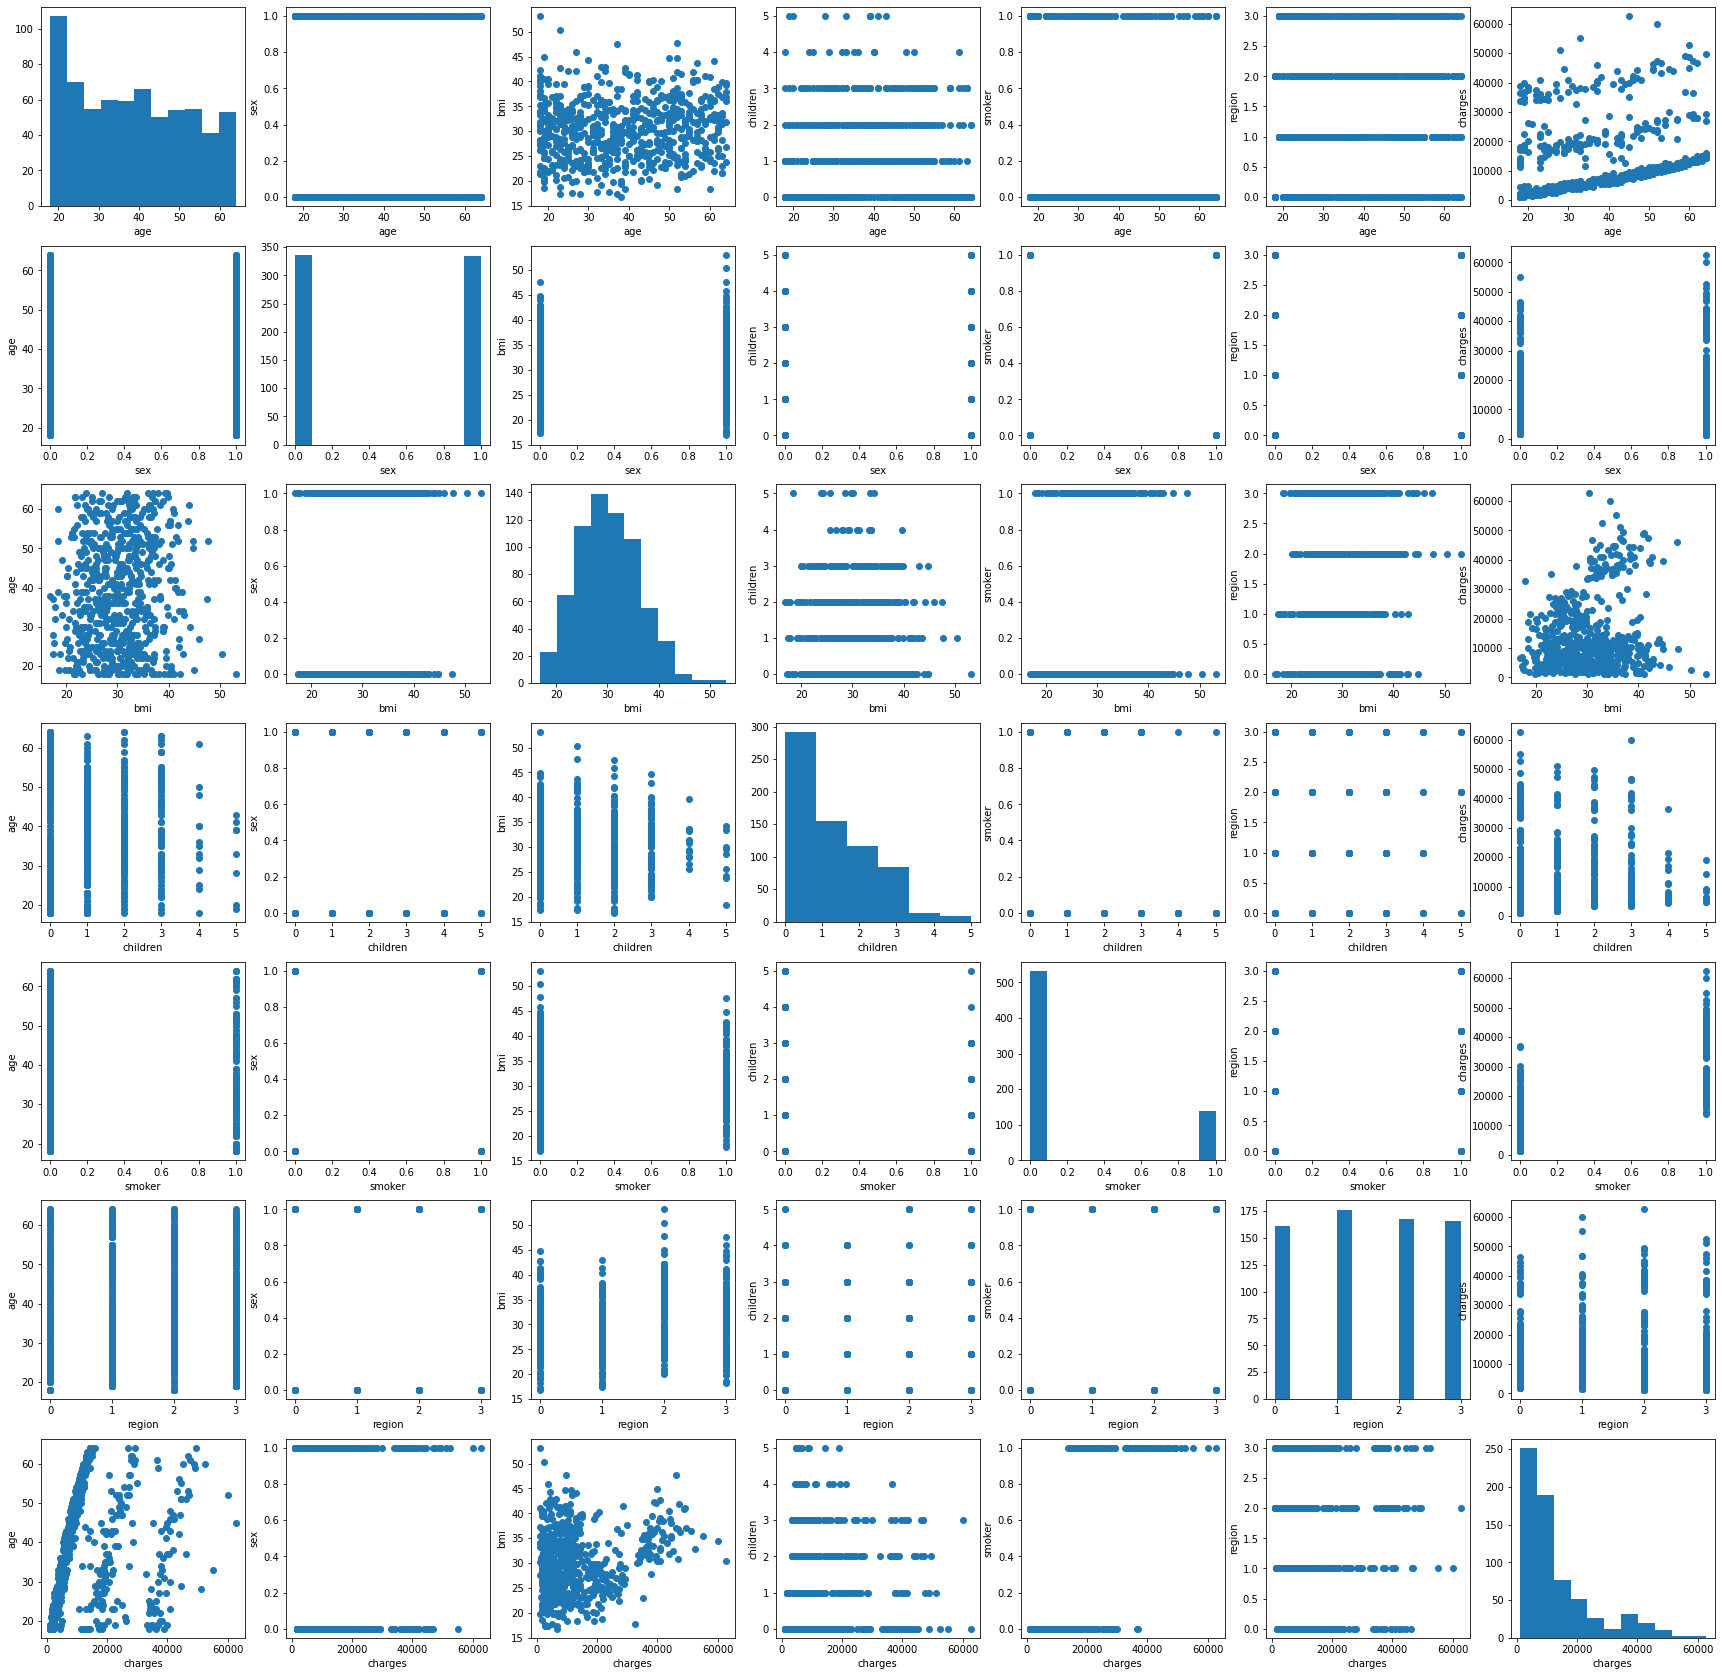

In [14]:
figure, axes = plt.subplots(nrows = dim, ncols = dim, figsize=(30,30))

for i in range(dim):
  for j in range(dim):
    if i == j:
      bins_ = 2+int(np.log2(N))
      if i == 3: bins_ = 6
      if i ==5: bins_ = 4*3
      axes[i][j].hist(casted_data[i], bins = bins_)
      axes[i][j].set_xlabel(header[i])
    else:
      axes[i][j].scatter(casted_data[i], casted_data[j])
      axes[i][j].set_xlabel(header[i])
      axes[i][j].set_ylabel(header[j])

### Корреляция признаков, выбросы

In [51]:
res = linregress(casted_data[0], casted_data[2])
if res.pvalue < 0.3: print('Линейная регрессионная модель значима: {:5.3f}x+{:5.3f}'.format(res.slope, res.intercept))
else: print('Линейная регрессионная модель не значима')

Линейная регрессионная модель значима: 0.037x+28.782


In [52]:
x = np.array([casted_data[0].min(), casted_data[0].max()])
y_regress = res.slope*x + res.intercept

In [33]:
q = np.quantile(casted_data[2], q=[0.25, 0.75])
interq = q[1]-q[0]
min = q[0]-interq*1.5
max = q[1]+interq*1.5
print(min,max)

13.375000000000004 46.535


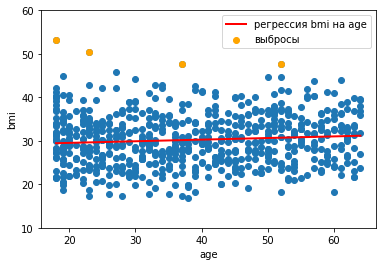

In [58]:
plt.scatter(casted_data[0], casted_data[2])
plt.xlabel(header[0])
plt.ylabel(header[2])
plt.plot(x, y_regress, color = 'red', linewidth = 2, label = 'регрессия {} на {}'.format(header[2], header[0]))
plt.scatter(casted_data[0][(casted_data[2] > max)], casted_data[2][(casted_data[2] > max)], color = 'orange', label = 'выбросы')
plt.legend(loc='upper right')

ax = plt.gca()
ax.set_ylim([10, 60])

None

### Кластеры

In [75]:
from sklearn.cluster import KMeans

In [77]:
np.array([casted_data[2], casted_data[6]]).T.shape

(670, 2)

In [80]:
model = KMeans(n_clusters=3)
clusters = model.fit_predict(np.array([casted_data[2], casted_data[6]]).T)

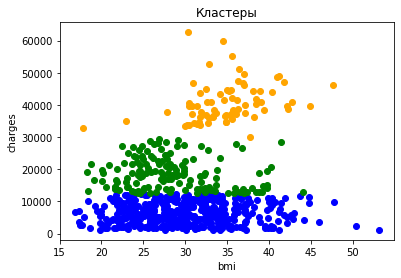

In [83]:
plt.scatter(casted_data[2][clusters==0], 
            casted_data[6][clusters==0], color='orange')
plt.scatter(casted_data[2][clusters==1], 
            casted_data[6][clusters==1], color='blue')
plt.scatter(casted_data[2][clusters==2], 
            casted_data[6][clusters==2], color='green')

plt.xlabel(header[2])
plt.ylabel(header[6])
plt.title('Кластеры')
None

### Типичные значения

In [99]:
1+ int(np.log2(len(casted_data[6])))

10

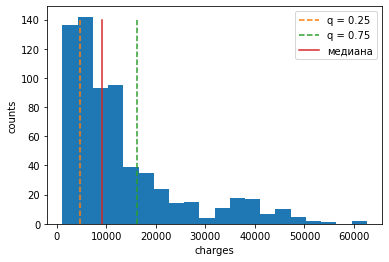

In [108]:
plt.hist(casted_data[6], bins = 20)
plt.xlabel('charges')
plt.ylabel('counts')

q = np.quantile(casted_data[6], q=[0.25, 0.5, 0.75])

plt.plot([q[0],q[0]], [0, 140], label = 'q = 0.25', linestyle='--')
plt.plot([q[2],q[2]], [0, 140], label = 'q = 0.75', linestyle='--')
plt.plot([q[1],q[1]], [0, 140], label = 'медиана')

plt.legend()
None

### Зависимость факта курения от пола

In [152]:
people = np.array([casted_data[1],casted_data[4]])
people.shape

(2, 670)

In [136]:
# female - 0, male - 1
# smoker no - 0, yes - 1
smoking_people = np.where(people[1] == 1, people[0], np.NAN)
smoking_people = smoking_people[~np.isnan(smoking_people)]
smoking_men = np.sum(smoking_people)
smoking_women = len(smoking_people) - smoking_men

In [137]:
print(smoking_men, smoking_women)

74.0 64.0


In [138]:
non_smoking_people = np.where(people[1] == 0, people[0], np.NAN)
non_smoking_people = non_smoking_people[~np.isnan(non_smoking_people)]
non_smoking_men = np.sum(non_smoking_people)
non_smoking_women = len(non_smoking_people) - smoking_men

In [140]:
print(non_smoking_men, non_smoking_women)

260.0 458.0


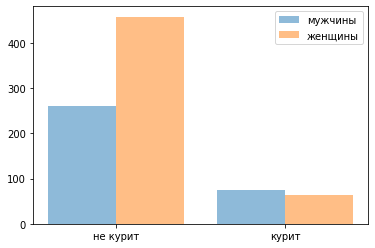

In [155]:
plt.bar(x=[-0.2,0.8], height=[non_smoking_men, smoking_men], alpha=0.5, width = 0.4, label='мужчины')
plt.bar(x=[0.2,1.2], height=[non_smoking_women, smoking_women], alpha=0.5, width = 0.4, label='женщины')

ticks = ['не курит', 'курит']
ax = plt.gca()
ax.set_xticks(range(0,2))
ax.set_xticklabels(ticks)

plt.legend()
None